<a href="https://colab.research.google.com/github/SisekoC/My-Notebooks/blob/main/siamese_network_with_triplet_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#One-Shot Learning: Siamese neural network with loss of triplet
##Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

target_shape = (200, 200)

##Loading data

In [2]:
cache_dir = Path(Path.home()) / '.keras'
anchor_images_path = cache_dir / 'left'
positive_images_path = cache_dir / 'right'

In [3]:
!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
From (redirected): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34&confirm=t&uuid=74326cc5-e053-4224-9f00-ac9aede2d438
To: /content/left.zip
100% 104M/104M [00:01<00:00, 71.9MB/s] 
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
From (redirected): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW&confirm=t&uuid=e268e806-1c4a-416d-b9b4-2a07e238b403
To: /content/right.zip
100% 10

##Data preparation

In [4]:
def preprocess_image(filename):
  img_string = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img_string, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, target_shape)
  return img

def preprocess_triplets(anchor, positive, negative):
  return (
      preprocess_image(anchor),
      preprocess_image(positive),
      preprocess_image(negative)
  )

In [5]:
# We need to make sure that the anchor and positive images are loaded in the right order so that we can compare them.
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

img_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate a list of negative images let's shuffle the list of available images
# and let's concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Dividing data into training and validation data
train_dataset = dataset.take(round(img_count * 0.8))
val_dataset = dataset.skip(round(img_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

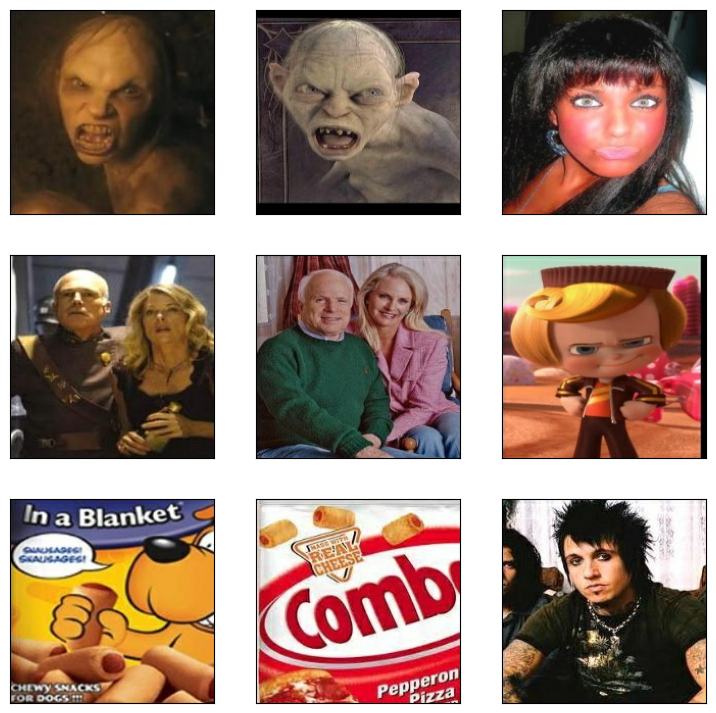

In [6]:
def visualize(anchor, positive, negative):

  def show(ax, img):
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  fig = plt.figure(figsize=(9, 9))

  axs = fig.subplots(3, 3)
  for i in range(3):
    show(axs[i, 0], anchor[i])
    show(axs[i, 1], positive[i])
    show(axs[i, 2], negative[i])

visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

#Model generator embedding

In [7]:
base_cnn = resnet.ResNet50(
    weights='imagenet', input_shape=target_shape +(3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation='relu')(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation='relu')(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name='Embedding')

trainable = False
for layer in base_cnn.layers:
  if layer.name == 'conv5_block1_out':
    trainable = True
  layer.trainable = trainable

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


##Siamese network model

In [8]:
class DistanceLayer(layers.Layer):

  # The layer responsible for calculating the distance between anchor embedding
  # and positive embedding and anchor embedding and negative embedding.

  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, anchor, positive, negative):
    ap_dist = tf.reduce_sum(tf.square(anchor - positive), -1)
    an_dist = tf.reduce_sum(tf.square(anchor - negative), -1)
    return (ap_dist, an_dist)


anchor_input = layers.Input(name='anchor', shape=target_shape + (3,))
positive_input = layers.Input(name='positive', shape=target_shape + (3,))
negative_input = layers.Input(name='negative', shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input))
)

siamese_net = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

##Bringing it all together

In [9]:
class SiameseModel(Model):

  def __init__(self, siamese_net, margin=0.5):
    super(SiameseModel, self).__init__()
    self.siamese_net = siamese_net
    self.margin = margin
    self.loss_tracker = metrics.Mean(name='loss')

  def call(self, inputs):
    return self.siamese_net(inputs)

  def train_step(self, data):
    with tf.GradientTape() as tape:
      loss = self._compute_loss(data)

    gradients = tape.gradient(loss, self.siamese_net.trainable_weights)

    self.optimizer.apply_gradients(
        zip(gradients, self.siamese_net.trainable_weights)
    )

    self.loss_tracker.update_state(loss)
    return {'loss': self.loss_tracker.result()}

  def test_step(self, data):
    loss = self._compute_loss(data)

    self.loss_tracker.update_state(loss)
    return {'loss': self.loss_tracker.result()}

  def _compute_loss(self, data):
    ap_dist, an_dist = self.siamese_net(data)

    loss = ap_dist - an_dist
    loss = tf.maximum(loss + self.margin, 0.0)
    return loss

  @property
  def metrics(self):
    return [self.loss_tracker]

##Training

In [10]:
siamese_model = SiameseModel(siamese_net)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 130s 565ms/step - loss: 0.6490 - val_loss: 0.3593
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 59s 394ms/step - loss: 0.3855 - val_loss: 0.3674
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 60s 400ms/step - loss: 0.3675 - val_loss: 0.3432
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 59s 391ms/step - loss: 0.3598 - val_loss: 0.3353
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 60s 400ms/step - loss: 0.3176 - val_loss: 0.3418
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 59s 391ms/step - loss: 0.3222 - val_loss: 0.3306
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 64s 421ms/step - loss: 0.2965 - val_loss: 0.3131
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 61s 401ms/step - loss: 0.3146 - val_loss: 0.3194
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 59s 389ms/step - loss: 0.2840 - val_loss: 0.3310
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 63s 420ms/step - loss: 0.2746 - val_loss: 0.3148


##Checking what the network has learned

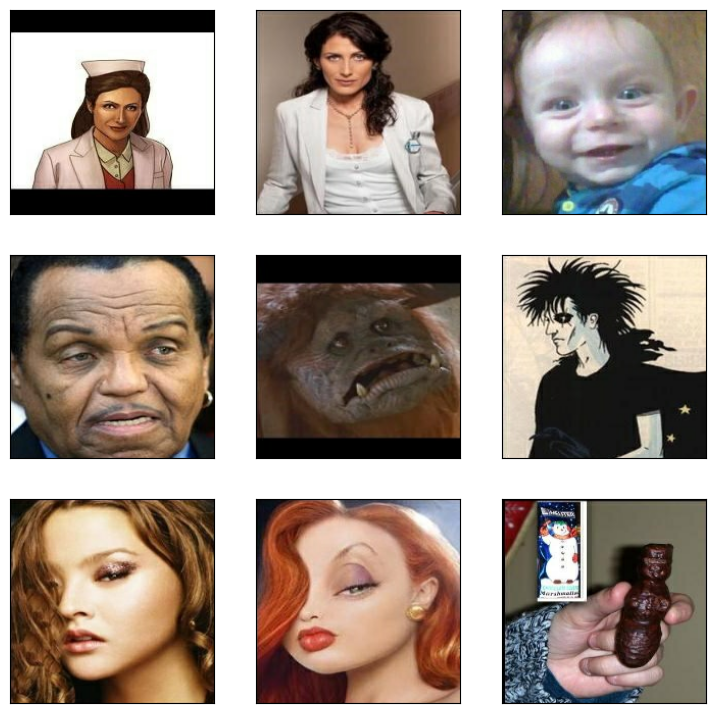

In [11]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative))
)

In [12]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print('Positive similarity:', positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print('Positive similarity:', negative_similarity.numpy())

Positive similarity: 0.99304605
Positive similarity: 0.98859847
